In [1]:
import torch
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, LeakyReLU
from torch_geometric.utils import scatter
from torch_geometric.nn import MetaLayer

class EdgeModel(torch.nn.Module):
    def __init__(self, nf, ef, gf, hidden_dim, num_layers, dropout=0.1):
        super().__init__()
        self.edge_mlp = Seq(Lin(nf * 2 + ef + gf + 2, hidden_dim),
                            LeakyReLU(),
                            nn.Dropout(p=dropout),
                            Lin(hidden_dim, hidden_dim),
                            LeakyReLU(),
                            nn.Dropout(p=dropout),
                            Lin(hidden_dim, hidden_dim),
                            LeakyReLU(),
                            nn.Dropout(p=dropout),
                            Lin(hidden_dim, ef))

    def forward(self, src, dest, edge_index, edge_attr, u, batch):
        # src, dest: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        out = torch.cat([src, dest, edge_index.t(), edge_attr, u.expand(src.shape[0], -1)], 1)
        return self.edge_mlp(out)


class NodeModel(torch.nn.Module):
    def __init__(self, nf, ef, gf, hidden_dim, dropout=0.1):
        super().__init__()
        self.node_mlp_1 = Seq(Lin(nf + ef + 1, hidden_dim), 
                              ReLU(), 
                              nn.Dropout(p=dropout), 
                              Lin(hidden_dim, hidden_dim),
                              ReLU(), 
                              nn.Dropout(p=dropout), 
                              Lin(hidden_dim, hidden_dim)
                             )
        self.node_mlp_2 = Seq(Lin(nf + hidden_dim + gf, hidden_dim),
                              LeakyReLU(),
                              nn.Dropout(p=dropout),
                              Lin(hidden_dim, hidden_dim),
                              LeakyReLU(),
                              nn.Dropout(p=dropout),
                              Lin(hidden_dim, hidden_dim),
                              LeakyReLU(),
                              nn.Dropout(p=dropout),
                              Lin(hidden_dim, nf))

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out1 = torch.cat([x[row], row.view(-1, 1), edge_attr], dim=1)
        out2 = torch.cat([x[col], col.view(-1, 1), edge_attr], dim=1)
        
        out1 = self.node_mlp_1(out1)
        out2 = self.node_mlp_1(out2)
        
        out1 = scatter(out1, col, dim=0, dim_size=x.size(0),
                      reduce='sum')
        out2 = scatter(out2, row, dim=0, dim_size=x.size(0),
                      reduce='sum')
        out = out1 + out2 
        
        out = out / torch.norm(out, p=2)
        
        out = torch.cat([x, out, u.expand(x.shape[0], -1)], dim=1)
        return self.node_mlp_2(out)

class GlobalModel(torch.nn.Module):
    def __init__(self, gf, num_nodes, output_dim, dropout=0.1):
        super().__init__()
        self.global_mlp = Seq(Lin(gf + num_nodes, hidden_dim),
                              LeakyReLU(), 
                              nn.Dropout(p=dropout),
                              Lin(hidden_dim, hidden_dim),
                              LeakyReLU(),
                              nn.Dropout(p=dropout),
                              Lin(hidden_dim, hidden_dim),
                              LeakyReLU(), 
                              nn.Dropout(p=dropout),
                              Lin(hidden_dim, output_dim))

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        out = torch.cat([
            u,
            x.t(),
        ], dim=1)
        return self.global_mlp(out)

In [2]:
from typing import Optional, Tuple

import torch
from torch import Tensor
class MetaLayer(torch.nn.Module):
    
    def __init__(
        self,
        edge_model: Optional[torch.nn.Module] = None,
        node_model: Optional[torch.nn.Module] = None,
        global_model: Optional[torch.nn.Module] = None,
    ):
        super().__init__()
        self.edge_model = edge_model
        self.node_model = node_model
        self.global_model = global_model

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        for item in [self.node_model, self.edge_model, self.global_model]:
            if hasattr(item, 'reset_parameters'):
                item.reset_parameters()

    def forward(
        self,
        x: Tensor,
        edge_index: Tensor,
        edge_attr: Optional[Tensor] = None,
        u: Optional[Tensor] = None,
        batch: Optional[Tensor] = None,
    ) -> Tuple[Tensor, Optional[Tensor], Optional[Tensor]]:
        
        row = edge_index[0]
        col = edge_index[1]

        if self.edge_model is not None:
            edge_attr = self.edge_model(x[row], x[col], edge_index, edge_attr, u,
                                        batch if batch is None else batch[row])

        if self.node_model is not None:
            x = self.node_model(x, edge_index, edge_attr, u, batch)

        if self.global_model is not None:
            u = self.global_model(x, edge_index, edge_attr, u, batch)

        return x, edge_attr, u


    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(\n'
                f'  edge_model={self.edge_model},\n'
                f'  node_model={self.node_model},\n'
                f'  global_model={self.global_model}\n'
                f')')

In [8]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, Dropout, LeakyReLU
from torch_geometric.utils import from_scipy_sparse_matrix

def meta_layer(nf, ef, gf, num_nodes, hidden_dim, output_dim, dropout=0.1):
    edge_model = EdgeModel(nf, ef, gf, hidden_dim, num_layers=4, dropout=dropout)
    node_model = NodeModel(nf, ef, gf, hidden_dim, dropout=dropout)
    global_model = GlobalModel(gf, num_nodes, output_dim, dropout=dropout)
    return MetaLayer(
        edge_model=edge_model,
        node_model=node_model,
        global_model=global_model)

class Discriminator(torch.nn.Module):
    def __init__(self, latent_dim):
        super(Discriminator, self).__init__()
        self.disc = Seq(Lin(latent_dim * 2, 32), LeakyReLU(), Lin(32, 1))
        
    def forward(self, h, s):
        return F.sigmoid(self.disc(torch.cat([h, s])))

class VGAE(torch.nn.Module):
    def __init__(self, num_nodes, nf, ef, gf, hidden_dim, latent_dim=64, dropout_rate=0.1, l2_regularization=0.01):
        super(VGAE, self).__init__()
        
        self.edge_index = torch.triu(torch.ones((input_dim, input_dim)), diagonal=1).nonzero(as_tuple=False).t()
        
        self.fake_x = torch.ones((num_nodes, nf))
        self.fake_edge_attr = torch.ones((self.edge_index.shape[1], ef))
        
        self.meta_encode_1 = meta_layer(nf, ef, gf, num_nodes, hidden_dim, hidden_dim, dropout=dropout_rate)
        self.meta_encode_2 = meta_layer(nf, ef, hidden_dim, num_nodes, hidden_dim, latent_dim * 2, dropout=dropout_rate)

        self.meta_decode_1 = meta_layer(nf, ef, latent_dim, num_nodes, hidden_dim, int(latent_dim / 2), dropout=dropout_rate)
        self.meta_decode_2 = meta_layer(nf, ef, int(latent_dim / 2), num_nodes, hidden_dim, gf, dropout=dropout_rate)
        self.meta_decode_3 = meta_layer(nf, ef, int(latent_dim / 4), num_nodes, hidden_dim, gf, dropout=dropout_rate)
        
        self.dropout = Dropout(p=dropout_rate)
        self.l2_regularization = l2_regularization

    def encode(self, x, edge_attr, u):
        x, edge_attr, u = self.meta_encode_1(x, self.edge_index, edge_attr=edge_attr, u=u)
        _, _, enc = self.meta_encode_2(x, self.edge_index, edge_attr=edge_attr, u=u)
        
        mu = enc[:,:64]
        logvar = enc[:,64:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x, edge_attr, u = self.meta_decode_1(self.fake_x, self.edge_index, edge_attr=self.fake_edge_attr, u=z)
        x, edge_attr, u = self.meta_decode_2(x, self.edge_index, edge_attr=edge_attr, u=u)
#         x, edge_attr, u = self.meta_decode_3(x, self.edge_index, edge_attr=edge_attr, u=u)
        return x, edge_attr, u

    def forward(self, x, edge_attr, u):
        mu, logvar = self.encode(x, edge_attr=edge_attr, u=u)

        z = self.reparameterize(mu, logvar)
        x, edge_attr, u = self.decode(z)
        return x, edge_attr, u, mu, logvar, z

    def loss_function(self, recon_x, x, recon_edge_attr, edge_attr, recon_u, u, mu, logvar, z):
        x_loss = F.mse_loss(recon_x, x, reduction='sum')
        edge_attr_loss = F.mse_loss(recon_edge_attr, edge_attr, reduction='sum')
#         u_loss = F.mse_loss(recon_u, u, reduction='sum')

        recon_loss = x_loss + edge_attr_loss 
    
        for (n1, n2) in edge_attr:
            print(n1, n2)

#         kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # L2 regularization
        l2_loss = 0.
        for param in model.parameters():
            l2_loss += torch.norm(param, p=2) ** 2

        # Total loss
        total_loss = recon_loss #+ kl_divergence + self.l2_regularization * l2_loss
        return total_loss / x.size(0)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# set the random seed for reproducibility
torch.manual_seed(0)

# define the hyperparameters
input_dim = 100  # size of the graph adjacency matrix
latent_dim = 64
lr = 1e-3

import torch
import torch.nn as nn
import torch.optim as optim
from utils import BrainGraphDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import transforms
from torch.utils.data import Dataset
from typing import List, Tuple
import numpy as np
from utils import BrainGraphDataset, get_data_labels
import os
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

annotations = 'annotations.csv'
dataroot = 'fc_matrices/hcp_100_ica/'
cwd = os.getcwd() + '/'

categories = ['patient_n','condition','bdi_before']

batch_graph_size = 1

data_labels = get_data_labels()
data_labels = data_labels[categories]

data_labels.loc[data_labels["condition"] == "P", "condition"] = 1
data_labels.loc[data_labels["condition"] == "E", "condition"] = -1
data_labels['condition'] = data_labels['condition'].astype('float64')



dataset = BrainGraphDataset(img_dir=cwd + dataroot,
                            annotations_file=cwd + dataroot + annotations,
                            transform=None, extra_data=data_labels, setting='lz')

dataroot = 'fc_matrices/psilo_ica_100_before/'
psilo_dataset = BrainGraphDataset(img_dir=cwd + dataroot,
                            annotations_file=cwd + annotations,
                            transform=None, extra_data=None, setting='lz')

psilo_train_loader = DataLoader(psilo_dataset, batch_size=batch_graph_size)

# define the data loaders
train_loader = DataLoader(dataset, batch_size=batch_graph_size, shuffle=True)
val_loader = psilo_train_loader

best_val_loss = float('inf')  # set to infinity to start
best_model_state = None

# define a dictionary to store the loss curves for each configuration
loss_curves = {}

train_losses = []
val_losses = []

nf = 1
ef = 1
gf = 2

hidden_dim = 32

model = VGAE(100, nf, ef, gf, hidden_dim, latent_dim, dropout_rate=0).to(device)
for name, param in model.named_parameters():
    if 'weight' in name:
        torch.nn.init.xavier_uniform_(param)

print(model)        
        
optimizer = optim.Adam(model.parameters(), lr=lr)

cpu
VGAE(
  (meta_encode_1): MetaLayer(
    edge_model=EdgeModel(
    (edge_mlp): Sequential(
      (0): Linear(in_features=7, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=32, out_features=32, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=32, out_features=32, bias=True)
      (7): LeakyReLU(negative_slope=0.01)
      (8): Dropout(p=0, inplace=False)
      (9): Linear(in_features=32, out_features=1, bias=True)
    )
  ),
    node_model=NodeModel(
    (node_mlp_1): Sequential(
      (0): Linear(in_features=3, out_features=32, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=32, out_features=32, bias=True)
      (4): ReLU()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=32, out_features=32, bias=True)
    )
    (node_mlp_2): Sequential(
      (0): Line

In [14]:
batch_size = 32
num_epochs = 40

for epoch in tqdm(range(num_epochs)):
    train_loss = 0.0
    val_loss = 0.0

    # training
    model.train()
    
    batch_counter = 0
    loss = 0.
    for batch_idx, (data, _) in enumerate(train_loader):
        
        data = data  # move data to device
        optimizer.zero_grad()

        (graph, lz, base_bdi) = data
        graph = graph.to(device)
        lz = lz.t().to(device)

        edge_attr = graph[:, model.edge_index[0], model.edge_index[1]].t().to(device)        
        
        u = base_bdi.to(device)
        
        recon_x, recon_edge_attr, recon_u, mu, logvar, z = model(lz, edge_attr, u)

        loss += model.loss_function(recon_x.view(lz.shape), lz, recon_edge_attr.view(edge_attr.shape), edge_attr, recon_u.view(u.shape), u, mu, logvar, z)
        
        batch_counter += 1
        if batch_counter % batch_size == 0 or len(train_loader) == 0:
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            loss = 0.
    # validation
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            (graph, lz, base_bdi) = data
            graph = graph.to(device)
            lz = lz.t().to(device)

            edge_attr = graph[:, model.edge_index[0], model.edge_index[1]].t().to(device)        
            u = base_bdi.to(device)

            recon_x, recon_edge_attr, recon_u, mu, logvar, z = model(lz, edge_attr, u)
            
            loss = model.loss_function(recon_x.view(lz.shape), lz, recon_edge_attr.view(edge_attr.shape), edge_attr, recon_u.view(u.shape), u, mu, logvar, z)
            
            val_loss += loss.item()
    # append losses to lists
    train_losses.append(train_loss/len(dataset))
    val_losses.append(val_loss/len(psilo_dataset))

    # save the model if the validation loss is at its minimum
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_model_state = model.state_dict()

    # print the lossestorch.nn.init.xavier_uniform_
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}\n')
    with open('gmm_train.txt', 'a') as f:
        f.write(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}\n')

# save the best model for this configuration
torch.save(best_model_state, f'vgae_weights/meta_layers_best_overfit.pt')

# add the loss curves to the dictionary
loss_curves[f"loss_curves"] = {"train_loss": train_losses, "val_loss": val_losses}

# save the loss curves to a file
with open("loss_curves_meta_layers.json", "w") as f:
    json.dump(loss_curves, f)

  0%|          | 0/40 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
import json
import matplotlib.pyplot as plt

# load in the loss curves from file
with open("loss_curves_meta_layers.json", "r") as f:
    loss_curves = json.load(f)

# plot the validation loss curves for each number of GMM components
plt.figure(figsize=(8, 6))
for n_comp, loss_dict in loss_curves.items():

    val_losses = loss_dict["val_loss"]
    epochs = range(1, len(val_losses) + 1)
    plt.plot(epochs, val_losses, label=f"{n_comp}")

# add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curves for MetaLayers")
plt.legend()
plt.ylim((1500, 3000))

# show the plot
plt.show()


In [ ]:
import json
import matplotlib.pyplot as plt

# load in the loss curves from file
with open("loss_curves_meta_layers.json", "r") as f:
    loss_curves = json.load(f)

# plot the validation loss curves for each number of GMM components
plt.figure(figsize=(8, 6))
for n_comp, loss_dict in loss_curves.items():
    val_losses = loss_dict["train_loss"]
    epochs = range(1, len(val_losses) + 1)
    plt.plot(epochs, val_losses, label=f"{n_comp}")

# add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curves for MetaLayers")
plt.legend()
plt.ylim((0, 100))


# show the plot
plt.show()

In [44]:
# load the weights
# model.load_state_dict(torch.load(f'vgae_weights/meta_layers_best_overfit.pt', map_location=device))

# set the model to evaluation mode
model.eval()

# calculate the validation loss
val_loss = 0.0
with torch.no_grad():
    for batch_idx, (data, _) in enumerate(train_loader):
        (graph, lz, base_bdi) = data
        graph = graph.to(device)
        lz = lz.t().to(device)

        edge_attr = graph[:, model.edge_index[0], model.edge_index[1]].t().to(device)        
        u = base_bdi.to(device)

        recon_x, recon_edge_attr, recon_u, mu, logvar = model(lz, edge_attr, u)
        loss = model.loss_function(recon_x.view(lz.shape), lz, recon_edge_attr.view(edge_attr.shape), edge_attr, recon_u.view(u.shape), u, mu, logvar)

        val_loss += loss.item()

# print the validation loss 
print(f'Meta Layer: Validation Loss = {val_loss/len(dataset):.4f}')

Meta Layer: Validation Loss = 1.2679


In [ ]:
# load the weights
model.load_state_dict(torch.load(f'vgae_weights/meta_layers_best_overfit.pt', map_location=device))

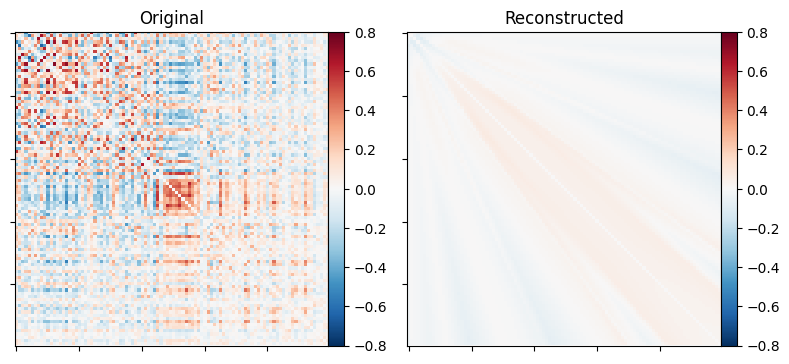

In [146]:
import matplotlib.pyplot as plt
from nilearn import plotting

# select a batch from the validation data loader
data, _ = next(iter(train_loader))

# pass the batch through the trained model to obtain the reconstructed output
(graph, lz, base_bdi) = data
graph = graph.to(device)
lz = lz.t().to(device)

edge_attr = graph[:, model.edge_index[0], model.edge_index[1]].t().to(device)        
u = base_bdi.to(device)

recon_x, recon_edge_attr, u, _, _ = model(lz, edge_attr, u)

recon_edge_attr = recon_edge_attr.detach()

# Create a SparseTensor object from the edge_index and edge_attr tensors
recon = torch.zeros((100, 100))

for i in range(model.edge_index.shape[1]):
    recon[model.edge_index[0,i], model.edge_index[1,i]] = recon_edge_attr[i]
    recon[model.edge_index[1,i], model.edge_index[0,i]] = recon_edge_attr[i]

# reshape the output to a 100x100 matrix (assuming the input_dim is 100x100)

# plot the original and reconstructed matrices for the first sample in the batch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plotting.plot_matrix(graph.view(100, 100), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax1)
ax1.set_title('Original')
plotting.plot_matrix(recon.detach(), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax2)
ax2.set_title('Reconstructed')
plt.show()

In [ ]:
dataroot = 'fc_matrices/psilo_ica_100_before'
cwd = os.getcwd() + '/'

psilo_dataset = BrainGraphDataset(img_dir=cwd + dataroot,
                            annotations_file=cwd + annotations,
                            transform=None, extra_data=None, setting='no_label')

psilo_train_loader = DataLoader(psilo_dataset, batch_size=batch_size)

# select a batch from the validation data loader
data, _ = next(iter(psilo_train_loader))

# pass the batch through the trained model to obtain the reconstructed output
recon, _, _ = model(data.view(-1, input_dim))

# reshape the output to a 100x100 matrix (assuming the input_dim is 100x100)
recon = recon.view(-1, 100, 100)

for i in range(3):
    # plot the original and reconstructed matrices for the first sample in the batch
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    plotting.plot_matrix(data[i], colorbar=True, vmax=0.8, vmin=-0.8, axes=ax1)
    ax1.set_title('Original')
    plotting.plot_matrix(recon[i].detach(), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax2)
    ax2.set_title('Reconstructed')
    plt.show()

In [ ]:
model = VGAE(input_dim, hidden_dim, latent_dim)

# load the weights
model.load_state_dict(torch.load(f'vgae_weights/gmm7_best.pt', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

# set the model to evaluation mode
model.eval()

# calculate the validation loss
val_losses = []
with torch.no_grad():
    for n_comp in range(2, 11):
        val_loss = 0.0
        model.load_state_dict(torch.load(f'vgae_weights/gmm{n_comp}_best.pt', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
        for batch_idx, (data, _) in enumerate(psilo_train_loader):
            recon, mu, logvar = model(data.view(-1, input_dim))
            loss = loss_function_gmm(recon, data.view(-1, input_dim), mu, logvar, n_components=5)
            val_loss += loss.item()
        val_loss /= len(psilo_dataset)
        val_losses.append(val_loss)
        print(f'gmm_{n_comp}: {val_loss} loss')

In [ ]:
n_components_list = list(range(2, 11))

# plot the validation loss for each n_components value
plt.plot(n_components_list, val_losses)
plt.xlabel('Number of Components')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Number of GMM Components')
plt.savefig('gmm_component_testing.jpg')
plt.show()

In [ ]:
hidden_dim = 256
latent_dim = 64
input_dim = 100 * 100

model = VGAE(input_dim, hidden_dim, latent_dim)

model.load_state_dict(torch.load('vgae_weights/gmm_5_hidden256_latent64.pt'))

psilo_mus = []
hcp_mus = []

with torch.no_grad():
    for batch_idx, (data, _) in enumerate(psilo_train_loader):
        mu, _= model.encode(data.view(-1, input_dim))
        psilo_mus.append(mu)
    
    for batch_idx, (data, _) in enumerate(train_loader):
        mu, _ = model.encode(data.view(-1, input_dim))
        hcp_mus.append(mu)
        
psilo_mus = torch.stack(psilo_mus, dim=1)
hcp_mus = torch.stack(hcp_mus, dim=1)
        
# Concatenate the encoded representations and create labels
x = torch.cat((psilo_mus, hcp_mus), dim=0)
labels = torch.cat((torch.zeros(psilo_mus.shape[0]), torch.ones(hcp_mus.shape[0])), dim=0)

from sklearn.manifold import TSNE

print(labels.shape)

# Use t-SNE to reduce the dimensionality of the encoded representations
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
x_tsne = tsne.fit_transform(x)

# Plot the t-SNE embeddings
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels, cmap='coolwarm')
plt.colorbar()
plt.show()

In [ ]:
# define the hyperparameters
input_dim = 100 * 100  # size of the graph adjacency matrix
lr = 1e-3
batch_size = 128
num_epochs = 300

annotations = 'annotations.csv'

dataroot = 'fc_matrices/hcp_100_ica/'
cwd = os.getcwd() + '/'

dataset = BrainGraphDataset(img_dir=cwd + dataroot,
                            annotations_file=cwd + dataroot + annotations,
                            transform=None, extra_data=None, setting='no_label')

# define the data loaders
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# instantiate the model


from tqdm import tqdm

import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_curves = {}
best_val_losses = {}  # create a dictionary to store the best validation loss for each configuration

best_n = 3

for hidden_dim in [256, 512]:
    for latent_dim in [64, 128]:
        train_losses = []
        val_losses = []
        model = VGAE(input_dim, hidden_dim, latent_dim).to(device)  # move model to device
        optimizer = optim.Adam(model.parameters(), lr=lr)
        best_val_loss = float('inf')  # initialize the best validation loss to infinity
        
        with open('gmm_train_overfit.txt', 'a') as f:
            f.write(f'Hidden dim: {hidden_dim}, latent_dim: {latent_dim}\n')
        
        for epoch in range(num_epochs):
            train_loss = 0.0
            val_loss = 0.0

            # training
            model.train()
            # define the optimizer and the loss function

            for batch_idx, (data, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
                data = data.to(device)  # move input data to device
                optimizer.zero_grad()

                recon, mu, logvar = model(data.view(-1, input_dim))
                loss = loss_function_gmm(recon, data.view(-1, input_dim), mu, logvar, n_components=best_n)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # validation
            model.eval()
            with torch.no_grad():
                for batch_idx, (data, _) in tqdm(enumerate(psilo_train_loader), total=len(psilo_train_loader)):
                    data = data.to(device)  # move input data to device
                    recon, mu, logvar = model(data.view(-1, input_dim))
                    loss = loss_function_gmm(recon, data.view(-1, input_dim), mu, logvar, n_components=best_n)
                    val_loss += loss.item()

            # append losses to lists
            train_losses.append(train_loss/len(train_dataset))
            val_losses.append(val_loss/len(psilo_dataset))

            with open('gmm_train_overfit.txt', 'a') as f:
                f.write(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}\n')
                
            # update the best validation loss and save the model weights if it's the best so far for this configuration
            if val_losses[-1] < best_val_loss:
                best_val_loss = val_losses[-1]
                best_val_losses[(hidden_dim, latent_dim)] = best_val_loss
                torch.save(model.state_dict(), f'vgae_weights/gmm_{best_n}_hidden{hidden_dim}_latent{latent_dim}.pt')

        # plot the losses
        plt.plot(val_losses, label=f'Validation Loss (hidden_dim={hidden_dim}, latent_dim={latent_dim})')
        
                # add the loss curves to the dictionary
        loss_curves[f"hidden{hidden_dim}_latent_dim{latent_dim}"] = {"train_loss": train_losses, "val_loss": val_losses}

# save the loss curves to a file
with open("loss_curves_overfit_new.json", "w") as f:
    json.dump(loss_curves, f)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import json
import matplotlib.pyplot as plt

# load in the loss curves from file
with open("loss_curves_overfit.json", "r") as f:
    loss_curves = json.load(f)

# plot the validation loss curves for each number of GMM components
plt.figure(figsize=(10, 8))
for n_comp, loss_dict in loss_curves.items():
    val_losses = loss_dict["val_loss"]
    epochs = range(1, len(val_losses) + 1)
    plt.plot(epochs, val_losses, label=f"{n_comp}")

# add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
plt.title("Validation Loss Curves for Different Net Architectures")
plt.legend()
plt.ylim((350, 500))


# show the plot
plt.show()


In [ ]:
# define the hyperparameters
input_dim = 100 * 100  # size of the graph adjacency matrix
hidden_dims = [256, 128, 64]
latent_dims = [64, 32, 16]
lr = 1e-3
batch_size = 128
num_epochs = 300

annotations = 'annotations.csv'

dataroot = 'fc_matrices/hcp_100_ica/'
cwd = os.getcwd() + '/'


# define the optimizer and the loss function
optimizer = optim.Adam(model.parameters(), lr=lr)

from tqdm import tqdm

import matplotlib.pyplot as plt

for hidden_dim in hidden_dims:
    for latent_dim in latent_dims:
        train_losses = []
        val_losses = []
        model = VGAE(input_dim, hidden_dim, latent_dim)
        
        # load in the model weights
        model.load_state_dict(torch.load(f'vgae_weights/gmm_5_hidden{hidden_dim}_latent{latent_dim}.pt'))
        
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for batch_idx, (data, _) in tqdm(enumerate(psilo_train_loader), total=len(psilo_train_loader)):
                recon, mu, logvar = model(data.view(-1, input_dim))
                loss = loss_function_gmm(recon, data.view(-1, input_dim), mu, logvar, n_components=5)
                val_loss += loss.item()
            val_losses.append(val_loss/len(psilo_dataset))

        # print the validation loss for this configuration
        print(f'Hidden Dim: {hidden_dim}, Latent Dim: {latent_dim}, Validation Loss: {val_losses[-1]:.4f}')


In [ ]:
class LatentMLP(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int, output_dim: int):
        super(LatentMLP, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [ ]:
# instantiate the VGAE model
hidden_dim = 256
latent_dim = 64
input_dim = 100 * 100
output_dim = 1

vgae = VGAE(input_dim, hidden_dim, latent_dim)

# load the trained VGAE weights
vgae.load_state_dict(torch.load('vgae_weights/gmm_5_hidden256_latent64.pt'))

# freeze the weights of the VGAE
for param in vgae.parameters():
    param.requires_grad = False

# instantiate the LatentMLP model
mlp = LatentMLP(latent_dim, hidden_dim, output_dim)

# define the optimizer and the loss function
optimizer = optim.Adam(mlp.parameters(), lr=lr)
criterion = nn.MSELoss()


dataroot = 'fc_matrices/psilo_100_ica/'
cwd = os.getcwd() + '/'

dataset = BrainGraphDataset(img_dir=cwd + dataroot,
                            annotations_file=annotations,
                            transform=None, extra_data=None, setting='no_label')

# # define the data loader for the new dataset
# new_dataset = MyNewDataset()
# new_loader = DataLoader(new_dataset, batch_size=batch_size)

# train the MLP on the new dataset
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, data in enumerate(psilo_train_loader, 0):
        # get the inputs
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # get the latent embeddings from the VGAE
        _, mu, _ = vgae(inputs)
        
        # pass the latent embeddings through the MLP
        outputs = mlp(mu)
        
        # calculate the loss and backpropagate
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished training')

# 